### Problem Statement: 
Generate a random rectangle, detect the object using Keras, and evaluate IOU for the prediction.

### Import the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback
from IPython.display import SVG
from sklearn.model_selection import train_test_split
%matplotlib inline

### Generate the images and bounding boxes

In [4]:
n_images = 50000
n_objects = 1
img_size = 16
min_obj_size = 1
max_obj_size = 8

In [5]:
def generate_training_set(n_images, n_objects, img_size, min_obj_size, max_obj_size):
    images = np.zeros((n_images, img_size, img_size))
    bounding_boxes = np.zeros((n_images, n_objects, 4))
    for i in range(n_images):
        for j in range(n_objects):
            width, height = np.random.randint(min_obj_size, max_obj_size, size = 2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            images[i, x : x + width, y : y + height] = 1.0
            bounding_boxes[i, j] = [x, y, width, height]
    return (images, bounding_boxes)

In [6]:
images, bounding_boxes = generate_training_set(n_images, n_objects, img_size, min_obj_size, max_obj_size)
print("Images shape:", images.shape)
print("Bounding Boxes shape:", bounding_boxes.shape)

Images shape: (50000, 16, 16)
Bounding Boxes shape: (50000, 1, 4)


### Visualize samples from the generated images

In [7]:
def display_image(index):
    plt.imshow(images[index].T, cmap = "binary", origin='lower', extent = [0, img_size, 0, img_size])
    for box in bounding_boxes[index]:
        plt.gca().add_patch(Rectangle((box[0], box[1]), box[2], box[3], ec = 'r', fc = 'none'))
    plt.xticks([])
    plt.yticks([])
    plt.show()

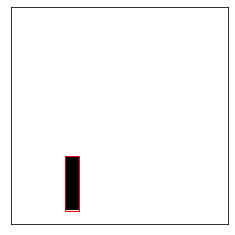

In [8]:
display_image(np.random.randint(0, n_images))

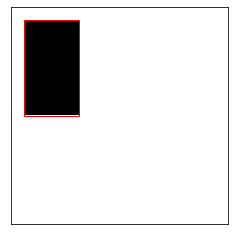

In [9]:
display_image(np.random.randint(0, n_images))

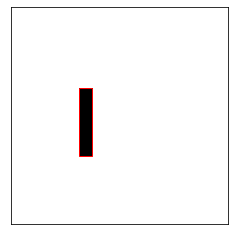

In [10]:
display_image(np.random.randint(0, n_images))

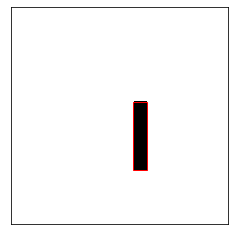

In [11]:
display_image(np.random.randint(0, n_images))

###Preprocess the images

In [12]:
x = (images.reshape(n_images, -1) - np.mean(images)) / np.std(images)
x.shape

(50000, 256)

In [13]:
y = bounding_boxes.reshape(n_images, -1) / img_size
y.shape

(50000, 4)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [15]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", x_test.shape)

x_train shape: (33500, 256)
x_test shape: (16500, 256)
y_train shape: (33500, 4)
y_test shape: (16500, 256)


###Train the model

In [16]:
def classifier():
    model = Sequential()
    model.add(Dense(256, input_dim = 256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    return model

In [17]:
model = classifier()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               65792     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 66,820
Trainable params: 66,820
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer = "adadelta", loss = 'mean_squared_error', metrics = ['accuracy'])

In [19]:
learning_rate_history = []
class Learning_Rate_History(Callback):
    def on_epoch_begin(self, epoch, logs = {}):
        learning_rate_history.append(K.get_value(model.optimizer.lr))
        print('Learning Rate:', learning_rate_history[-1])

In [20]:
model.fit(x_train, y_train, epochs = 30, validation_split = 0.1, callbacks = [Learning_Rate_History()])

Learning Rate: 0.001
Epoch 1/30
943/943 [==============================] - 2s 1ms/step - loss: 0.7030 - accuracy: 0.2570 - val_loss: 0.5693 - val_accuracy: 0.2672
Learning Rate: 0.001
Epoch 2/30
943/943 [==============================] - 1s 1ms/step - loss: 0.4852 - accuracy: 0.2802 - val_loss: 0.4159 - val_accuracy: 0.2782
Learning Rate: 0.001
Epoch 3/30
943/943 [==============================] - 1s 1ms/step - loss: 0.3702 - accuracy: 0.2930 - val_loss: 0.3333 - val_accuracy: 0.2970
Learning Rate: 0.001
Epoch 4/30
943/943 [==============================] - 1s 1ms/step - loss: 0.3053 - accuracy: 0.3102 - val_loss: 0.2843 - val_accuracy: 0.3107
Learning Rate: 0.001
Epoch 5/30
943/943 [==============================] - 1s 1ms/step - loss: 0.2651 - accuracy: 0.3242 - val_loss: 0.2517 - val_accuracy: 0.3200
Learning Rate: 0.001
Epoch 6/30
943/943 [==============================] - 1s 1ms/step - loss: 0.2369 - accuracy: 0.3377 - val_loss: 0.2275 - val_accuracy: 0.3367
Learning Rate: 0.001
E



### Predict bounding boxes

In [21]:
y_pred = model.predict(x_test)
box_pred = y_pred * img_size
box_pred.shape

(16500, 4)

In [22]:
def IOU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = w1 * h1 + w2 * h2 - I # Union = Total Area - I
    return I / U

In [23]:
iou = [IOU(y_test[i], y_pred[i]) for i in range(len(x_test))]

## Visualize the predictions on validation set



In [24]:
def display(x, box, box_pred):
    index = np.random.randint(0, len(x))
    plt.imshow(x[index].reshape(16, 16).T, cmap = 'binary', origin = 'lower', extent = [0, img_size, 0, img_size])
    plt.gca().add_patch(Rectangle((box_pred[index][0], box_pred[index][1]),
                                      box_pred[index][2], box_pred[index][3],
                                      ec = 'r', fc = 'none'))
    plt.title("IOU: " + str(iou[index]))
    plt.xticks([])
    plt.yticks([])
    plt.show()

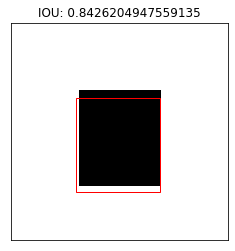

In [0]:
display(x_test, y_test, box_pred)

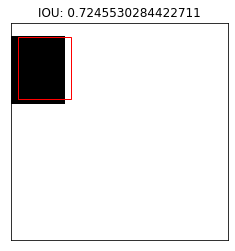

In [0]:
display(x_test, y_test, box_pred)

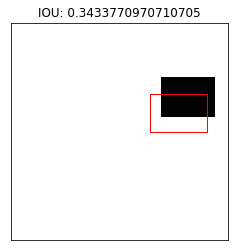

In [0]:
display(x_test, y_test, box_pred)

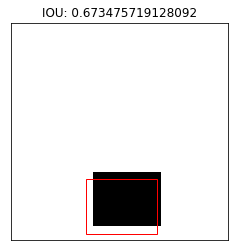

In [0]:
display(x_test, y_test, box_pred)